# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# Preprocessing
from robusta.preprocessing import *
from robusta.pipeline import *

# Eval
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from robusta.crossval import *

# Feature importance & selector
from robusta.importance import GroupPermutationImportance
from robusta.selector import *

# Data
from catboost.datasets import adult

# Model
from sklearn.linear_model import *
from lightgbm import LGBMRegressor, LGBMClassifier

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
TARGET = 'SalePrice'

train = pd.read_csv('./house/data/train.csv', index_col='Id')
test =  pd.read_csv('./house/data/test.csv',  index_col='Id')

y_train = train[TARGET]
train.drop(columns=TARGET, inplace=True)

train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


# Feature Generating

In [3]:
prep_pipe = FeatureUnion([
    ("cat_freq", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        FrequencyEncoder(),
        ColumnGrouper('CatFreq'),
    )),
    ("cat_ohe", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        DummyEncoder(),
        ColumnGrouper('CatOHE'),
    )),
    ("cat_diff", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        BackwardDifferenceEncoder(),
        ColumnGrouper('CatDiff'),
    )),
    ("cat_poly", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        PolynomialEncoder(),
        ColumnGrouper('CatPoly'),
    )),
    ("cat_svd", make_pipeline(
        TypeSelector("object"),
        SimpleImputer('mode'),
        Categorizer(),
        SVDEncoder(),
        ColumnGrouper('CatSVD'),
    )),
    #("cat_bin", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    BinaryEncoder(),
    #    ColumnGrouper('CatBin'),
    #)),
    #("cat_helm", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    HashingEncoder(),
    #    ColumnGrouper('CatHelm'),
    #)),
    #("cat_sum", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    SumEncoder(),
    #    ColumnGrouper('CatSum'),
    #)),
    #("cat_hash", make_pipeline(
    #    TypeSelector("object"),
    #    SimpleImputer('mode'),
    #    HashingEncoder(),
    #    ColumnGrouper('CatHash'),
    #)),
    #("num_std", make_pipeline(
    #    TypeSelector(np.number),
    #    StandardScaler(),
    #    SimpleImputer('mean'),
    #    ColumnGrouper('NumStd'),
    #)),
    ("num_rank", make_pipeline(
        TypeSelector(np.number),
        QuantileTransformer(),
        SimpleImputer('median'),
        ColumnGrouper('NumRank'),
    )),
    ("num_power", make_pipeline(
        TypeSelector(np.number),
        PowerTransformer(),
        SimpleImputer('median'),
        ColumnGrouper('NumPower'),
    )),
    ("num_minmax", make_pipeline(
        TypeSelector(np.number),
        MinMaxScaler(),
        SimpleImputer('mean'),
        ColumnGrouper('NumMinMax'),
    )),
    ("num_gr", make_pipeline(
        TypeSelector(np.number),
        GaussRankTransformer(),
        SimpleImputer('median'),
        ColumnGrouper('NumGR'),
    )),
])

X_train = prep_pipe.fit_transform(train)
X_test = prep_pipe.transform(test)

# Model

In [4]:
from sklearn.base import clone, BaseEstimator, RegressorMixin, ClassifierMixin


class MultiIndexRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, regressor):
        self.regressor = regressor
        
    def fit(self, X, y, **fit_params):
        self.regressor_ = clone(self.regressor)
        self.regressor_.fit(X.values, y, **fit_params)
        return self
    
    def predict(self, X):
        return self.regressor_.predict(X.values)
    
    @property
    def feature_importances_(self):
        return self.regressor_.feature_importances_

    @property
    def coef_(self):
        return self.regressor_.coef_
    

class MultiIndexClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifier):
        self.classifier = classifier
        
    def fit(self, X, y, **fit_params):
        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X.values, y, **fit_params)
        return self
    
    def predict(self, X):
        return self.classifier_.predict(X.values)
    
    def predict_proba(self, X):
        return self.classifier_.predict_proba(X.values)
    
    @property
    def classes_(self):
        return self.classifier_.classes_


model = LGBMRegressor()
model = MultiIndexRegressor(model)
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

# Task

In [5]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

scoring = lambda estimator, X, y: -mean_squared_log_error(y, estimator.predict(X))**0.5
cv = 5

# Baseline

In [11]:
# Full set
result = crossval(model, cv, X_train, y_train, X_new=X_test,
                  scoring=scoring, verbose=2, n_jobs=None)

[23:55:58]  TransformedTargetRegressor

[23:56:00]  VAL 1:   -0.1154
[23:56:02]  VAL 2:   -0.1433
[23:56:04]  VAL 3:   -0.1340
[23:56:05]  VAL 4:   -0.1166
[23:56:07]  VAL 5:   -0.1352

[23:56:07]  VALID:   -0.1289 ± 0.0110



In [12]:
# Simple subset
features = ['NumGR', 'CatFreq']

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=None)

[23:56:08]  TransformedTargetRegressor

[23:56:08]  VAL 1:   -0.1210
[23:56:09]  VAL 2:   -0.1449
[23:56:09]  VAL 3:   -0.1381
[23:56:09]  VAL 4:   -0.1216
[23:56:09]  VAL 5:   -0.1358

[23:56:10]  VALID:   -0.1323 ± 0.0095



# Group Permutation Importance

In [13]:
perm = GroupPermutationImportance(model, cv=cv, scoring=scoring, n_repeats=5, n_jobs=None)
perm.fit(X_train, y_train)

perm.feature_importances_

CatFreq      0.005503
CatOHE       0.009106
CatDiff      0.009975
CatPoly      0.024395
CatSVD       0.056116
NumRank      0.354505
NumPower     0.367605
NumMinMax    0.368374
NumGR        0.369670
dtype: float64

<IPython.core.display.Javascript object>


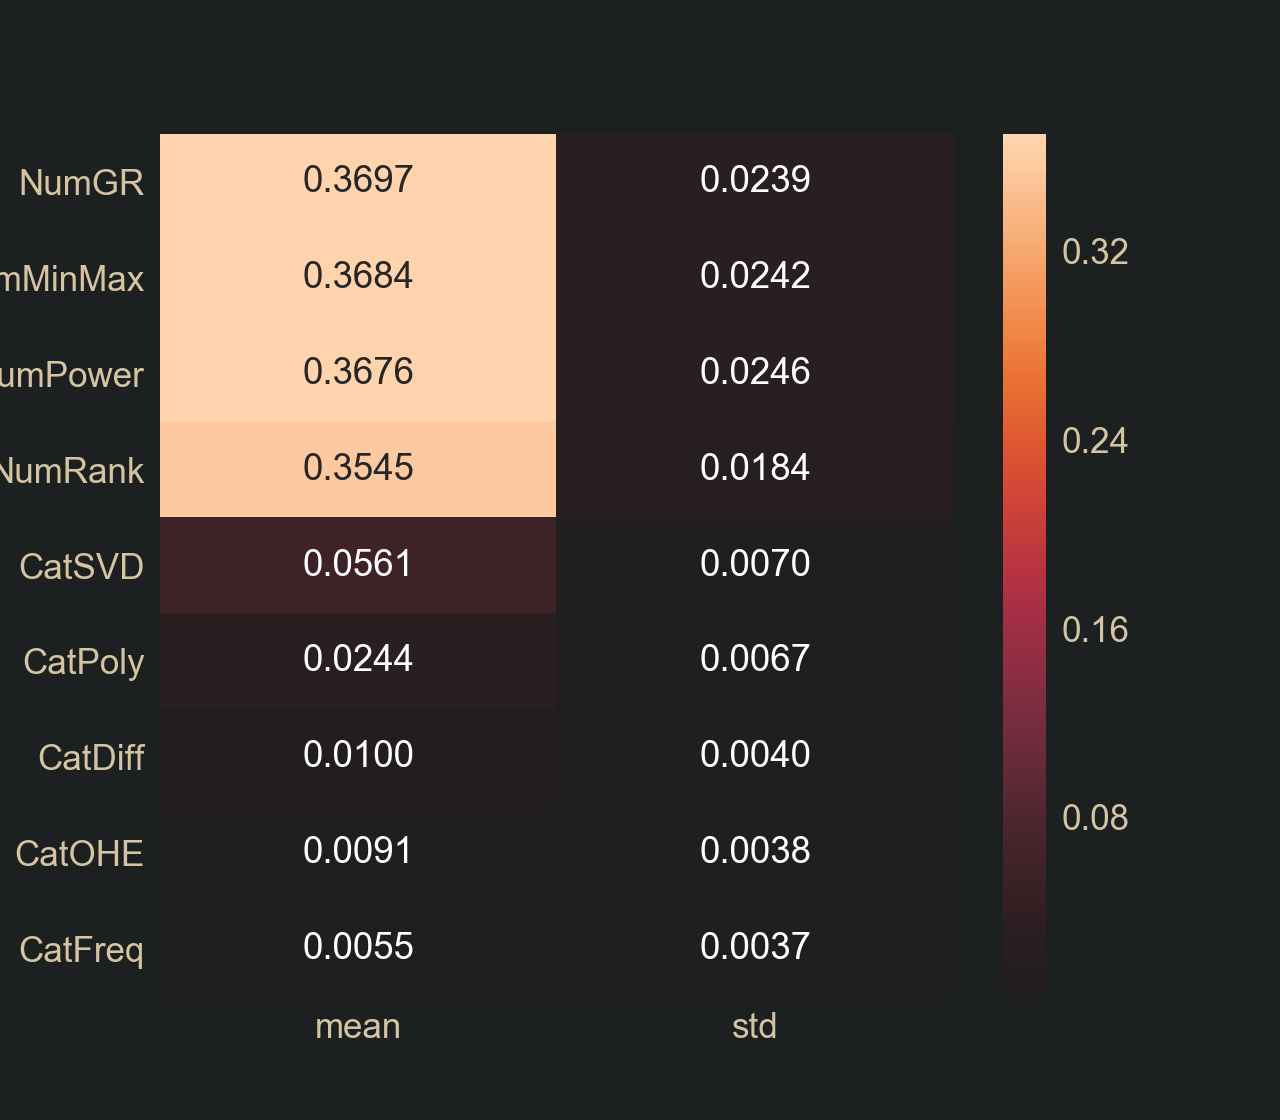

In [14]:
%matplotlib notebook

imp = pd.concat([perm.feature_importances_, perm.feature_importances_std_], axis=1)
imp.rename(columns={0: 'mean', 1: 'std'}, inplace=True)
imp.sort_values('mean', ascending=False, inplace=True)

sns.heatmap(imp, annot=True, fmt='0.4f', cmap='icefire', center=0)
plt.show()

# Group Permutation RFE

In [15]:
selector = GroupPermutationRFE(model, cv=cv, scoring=scoring, n_repeats=3,
                               min_features=1, verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[23:58:16] ITER: 1/9      SUBSET: 9/9      SCORE: -0.1289 ± 0.0110      ETA: 6 min 9 sec
[23:59:03] ITER: 2/9      SUBSET: 8/9      SCORE: -0.1289 ± 0.0111      ETA: 5 min 26 sec
[23:59:47] ITER: 3/9      SUBSET: 7/9      SCORE: -0.1290 ± 0.0111      ETA: 4 min 35 sec
[00:00:30] ITER: 4/9      SUBSET: 6/9      SCORE: -0.1289 ± 0.0111      ETA: 3 min 45 sec
[00:01:05] ITER: 5/9      SUBSET: 5/9      SCORE: -0.1276 ± 0.0104      ETA: 2 min 52 sec
[00:01:10] ITER: 6/9      SUBSET: 4/9      SCORE: -0.1386 ± 0.0085      ETA: 1 min 50 sec
[00:01:15] ITER: 7/9      SUBSET: 3/9      SCORE: -0.1386 ± 0.0087      ETA: 1 min 4 sec
[00:01:18] ITER: 8/9      SUBSET: 2/9      SCORE: -0.1385 ± 0.0085      ETA: 28 sec
[00:01:20] ITER: 9/9      SUBSET: 1/9      SCORE: -0.1388 ± 0.0098      ETA: 0 ms
Iterations limit exceed!


GroupPermutationRFE(cv=5,
                    estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                         inverse_func=<ufunc 'expm1'>,
                                                         regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                               class_weight=None,
                                                                                                               colsample_bytree=1.0,
                                                                                                               importance_type='split',
                                                                                                               learning_rate=0.1,
                                                                                                               max_depth=-1,
                     

<IPython.core.display.Javascript object>


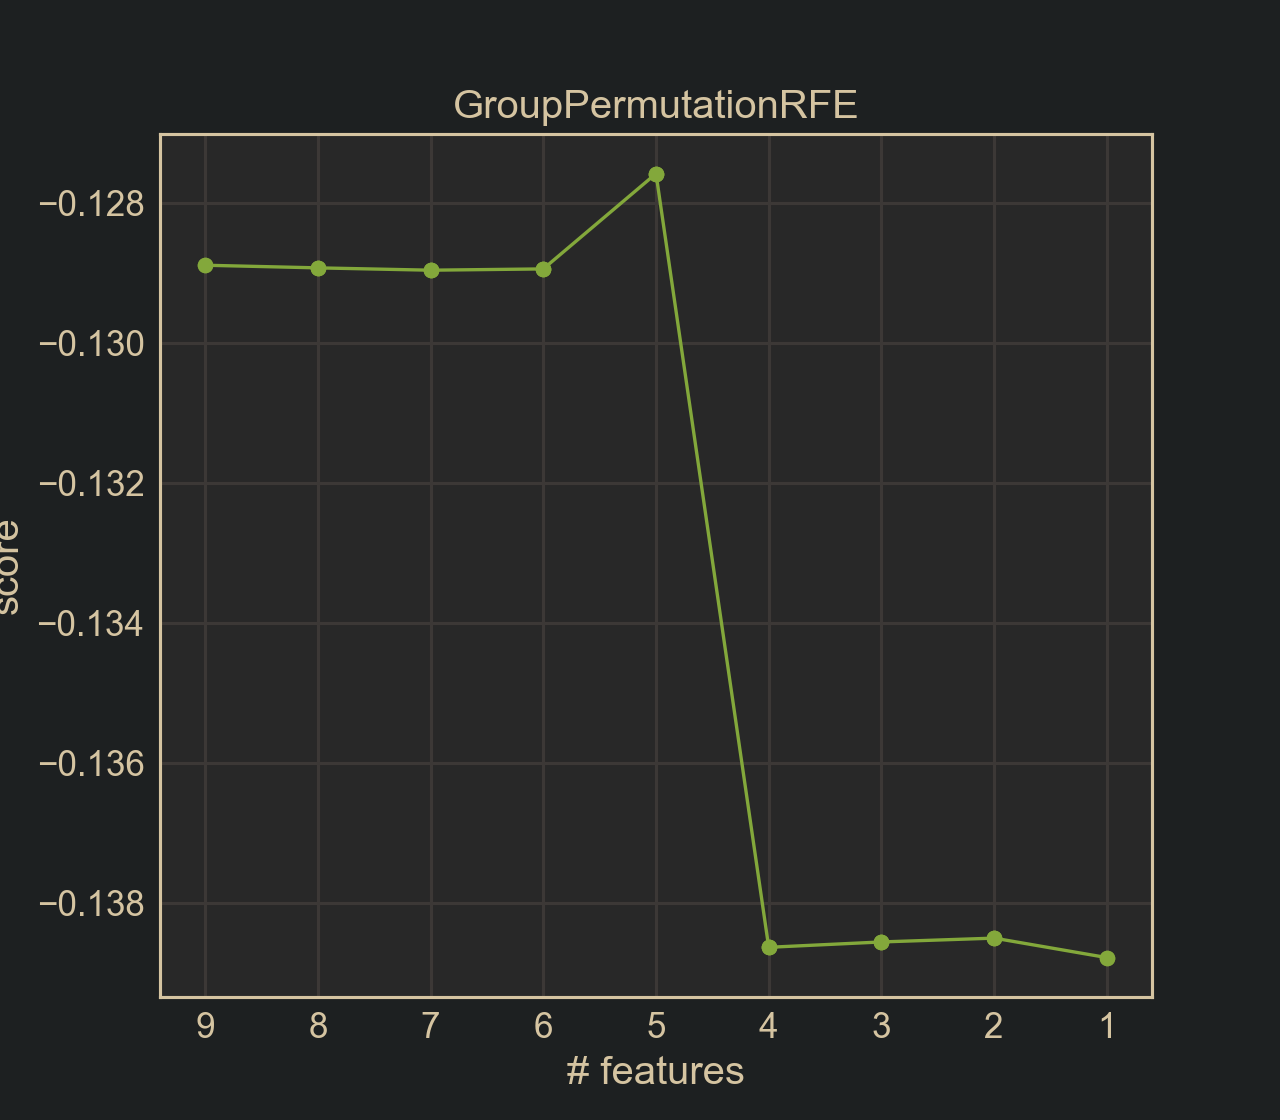

(<Figure size 640x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x141084eb8>)

In [22]:
%matplotlib notebook

selector.plot_subset(marker='o', color='g')

In [24]:
features = selector.get_subset()
model = MultiIndexRegressor(LGBMRegressor())
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[00:03:23]  TransformedTargetRegressor

[00:03:29]  VAL 1:   -0.1137
[00:03:29]  VAL 2:   -0.1403
[00:03:29]  VAL 3:   -0.1337
[00:03:29]  VAL 4:   -0.1169
[00:03:29]  VAL 5:   -0.1333

[00:03:29]  VALID:   -0.1276 ± 0.0104



# Group Random Selector

In [25]:
selector = GroupRandomSelector(model, cv=cv, scoring=scoring, max_iter=20,
                               min_features=1, max_features=5, weights='uniform',
                               verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[00:03:42] ITER: 1/20      SUBSET: 3/9      SCORE: -0.1312 ± 0.0090      ETA: 23 sec
[00:03:44] ITER: 2/20      SUBSET: 4/9      SCORE: -0.1284 ± 0.0105      ETA: 29 sec
[00:03:50] ITER: 3/20      SUBSET: 4/9      SCORE: -0.1291 ± 0.0112      ETA: 52 sec
[00:03:56] ITER: 4/20      SUBSET: 4/9      SCORE: -0.1283 ± 0.0092      ETA: 1 min 0 sec
[00:03:58] ITER: 5/20      SUBSET: 3/9      SCORE: -0.1321 ± 0.0091      ETA: 49 sec
[00:03:59] ITER: 6/20      SUBSET: 4/9      SCORE: -0.1303 ± 0.0090      ETA: 41 sec
[00:04:00] ITER: 7/20      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115      ETA: 34 sec
[00:04:05] ITER: 8/20      SUBSET: 3/9      SCORE: -0.1823 ± 0.0096      ETA: 36 sec
[00:04:06] ITER: 9/20      SUBSET: 1/9      SCORE: -0.1378 ± 0.0075      ETA: 30 sec
[00:04:08] ITER: 10/20      SUBSET: 4/9      SCORE: -0.1309 ± 0.0084      ETA: 26 sec
[00:04:09] ITER: 11/20      SUBSET: 3/9      SCORE: -0.1386 ± 0.0087      ETA: 23 sec
[00:04:17] ITER: 12/20      SUBSET: 5/9      SCORE: -0.129

GroupRandomSelector(cv=5,
                    estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                         inverse_func=<ufunc 'expm1'>,
                                                         regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                               class_weight=None,
                                                                                                               colsample_bytree=1.0,
                                                                                                               importance_type='split',
                                                                                                               learning_rate=0.1,
                                                                                                               max_depth=-1,
                     

<IPython.core.display.Javascript object>


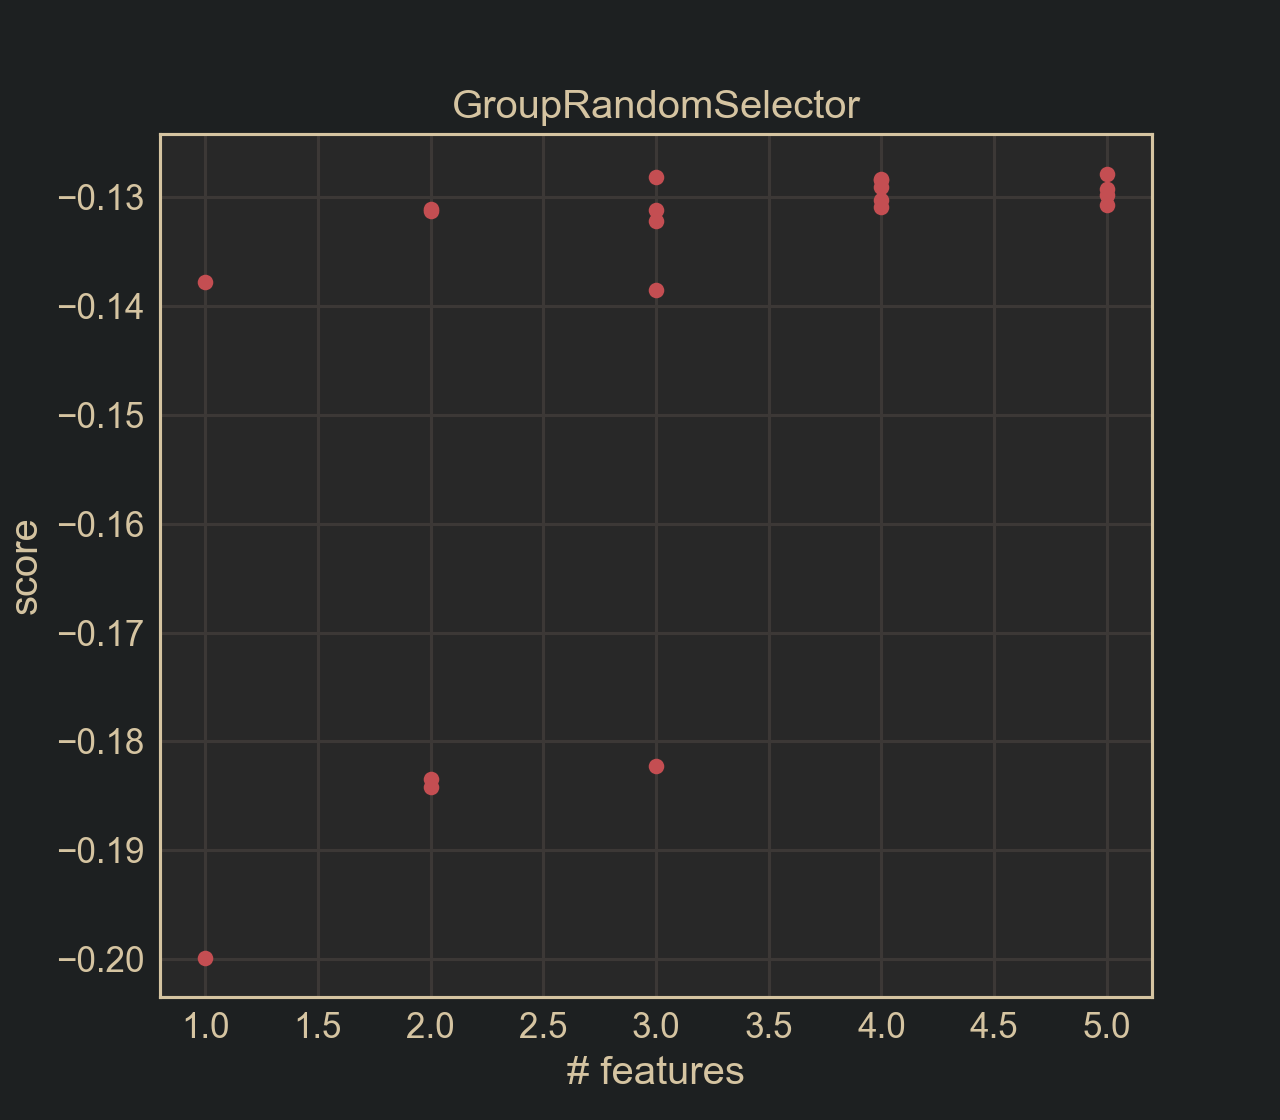

(<Figure size 640x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142a5e4a8>)

In [29]:
%matplotlib notebook

selector.plot_subset(marker='o', color='r')

In [30]:
features = selector.get_subset()

model = LGBMRegressor()
model = MultiIndexRegressor(model)
model = TransformedTargetRegressor(model, np.log1p, np.expm1)

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[00:05:21]  TransformedTargetRegressor

[00:05:27]  VAL 1:   -0.1141
[00:05:28]  VAL 2:   -0.1403
[00:05:28]  VAL 3:   -0.1336
[00:05:28]  VAL 4:   -0.1181
[00:05:28]  VAL 5:   -0.1329

[00:05:28]  VALID:   -0.1278 ± 0.0100



# Group Exhaustive Selector
### (Brute-force)

In [31]:
selector = GroupExhaustiveSelector(model, cv=cv, scoring=scoring,
                                   min_features=1, max_features=3,
                                   verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[00:05:40] ITER: 1/129      SUBSET: 1/9      SCORE: -0.1950 ± 0.0105      ETA: 53 sec
[00:05:41] ITER: 2/129      SUBSET: 1/9      SCORE: -0.1899 ± 0.0139      ETA: 58 sec
[00:05:41] ITER: 3/129      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115      ETA: 1 min 5 sec
[00:05:42] ITER: 4/129      SUBSET: 1/9      SCORE: -0.1814 ± 0.0087      ETA: 1 min 14 sec
[00:05:47] ITER: 5/129      SUBSET: 1/9      SCORE: -0.1834 ± 0.0090      ETA: 2 min 52 sec
[00:05:47] ITER: 6/129      SUBSET: 1/9      SCORE: -0.1378 ± 0.0075      ETA: 2 min 38 sec
[00:05:48] ITER: 7/129      SUBSET: 1/9      SCORE: -0.1386 ± 0.0092      ETA: 2 min 26 sec
[00:05:49] ITER: 8/129      SUBSET: 1/9      SCORE: -0.1371 ± 0.0091      ETA: 2 min 18 sec
[00:05:50] ITER: 9/129      SUBSET: 1/9      SCORE: -0.1388 ± 0.0098      ETA: 2 min 12 sec
[00:05:50] ITER: 10/129      SUBSET: 2/9      SCORE: -0.1899 ± 0.0112      ETA: 2 min 4 sec
[00:05:51] ITER: 11/129      SUBSET: 2/9      SCORE: -0.1904 ± 0.0114      ETA: 2 min 4 sec
[

[00:09:56] ITER: 88/129      SUBSET: 3/9      SCORE: -0.1282 ± 0.0106      ETA: 1 min 58 sec
[00:09:59] ITER: 89/129      SUBSET: 3/9      SCORE: -0.1305 ± 0.0088      ETA: 1 min 55 sec
[00:10:01] ITER: 90/129      SUBSET: 3/9      SCORE: -0.1315 ± 0.0083      ETA: 1 min 52 sec
[00:10:04] ITER: 91/129      SUBSET: 3/9      SCORE: -0.1299 ± 0.0077      ETA: 1 min 49 sec
[00:10:06] ITER: 92/129      SUBSET: 3/9      SCORE: -0.1317 ± 0.0091      ETA: 1 min 46 sec
[00:10:07] ITER: 93/129      SUBSET: 3/9      SCORE: -0.1311 ± 0.0096      ETA: 1 min 43 sec
[00:10:09] ITER: 94/129      SUBSET: 3/9      SCORE: -0.1313 ± 0.0084      ETA: 1 min 39 sec
[00:10:17] ITER: 95/129      SUBSET: 3/9      SCORE: -0.1822 ± 0.0112      ETA: 1 min 38 sec
[00:10:19] ITER: 96/129      SUBSET: 3/9      SCORE: -0.1297 ± 0.0103      ETA: 1 min 35 sec
[00:10:21] ITER: 97/129      SUBSET: 3/9      SCORE: -0.1284 ± 0.0106      ETA: 1 min 32 sec
[00:10:23] ITER: 98/129      SUBSET: 3/9      SCORE: -0.1297 ± 0.0100 

GroupExhaustiveSelector(cv=5,
                        estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                             inverse_func=<ufunc 'expm1'>,
                                                             regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                                   class_weight=None,
                                                                                                                   colsample_bytree=1.0,
                                                                                                                   importance_type='split',
                                                                                                                   learning_rate=0.1,
                                                                                                                  

In [37]:
selector.trials_

[FeatureSubset(Index(['CatFreq'], dtype='object')),
 FeatureSubset(Index(['CatOHE'], dtype='object')),
 FeatureSubset(Index(['CatDiff'], dtype='object')),
 FeatureSubset(Index(['CatPoly'], dtype='object')),
 FeatureSubset(Index(['CatSVD'], dtype='object')),
 FeatureSubset(Index(['NumRank'], dtype='object')),
 FeatureSubset(Index(['NumPower'], dtype='object')),
 FeatureSubset(Index(['NumMinMax'], dtype='object')),
 FeatureSubset(Index(['NumGR'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'CatOHE'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'CatDiff'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'CatPoly'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'CatSVD'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'NumRank'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'NumPower'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'NumMinMax'], dtype='object')),
 FeatureSubset(Index(['CatFreq', 'NumGR'], dtype='object')),
 FeatureSubset(Index(['CatOHE'

<IPython.core.display.Javascript object>


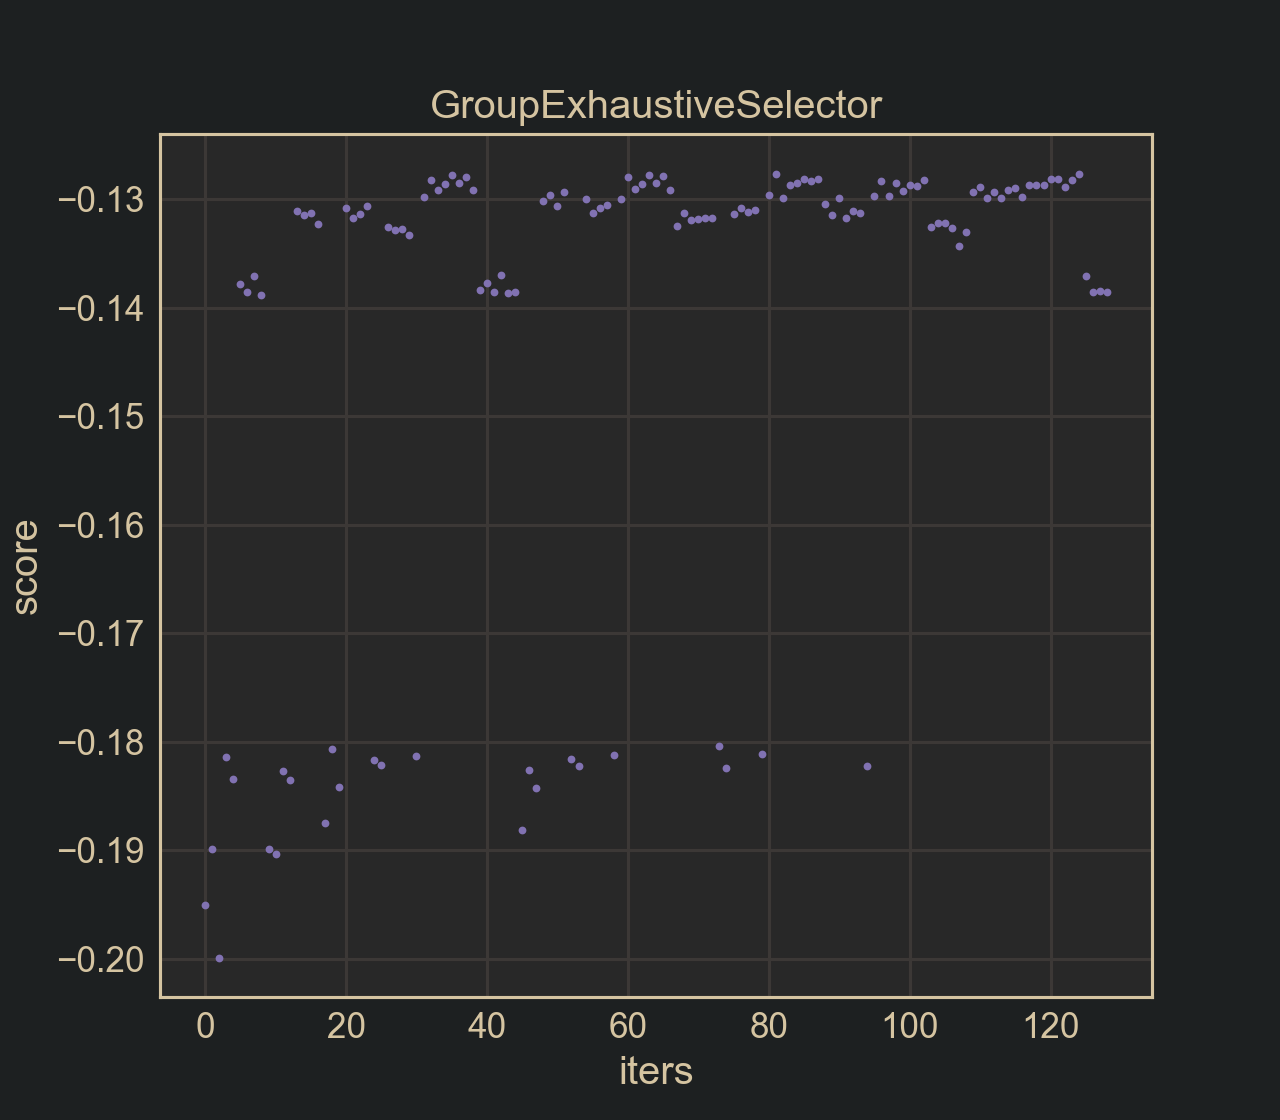

(<Figure size 640x560 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1413bda90>)

In [39]:
%matplotlib notebook

selector.plot_progress(color='m', marker='.')

In [41]:
features = selector.get_subset()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[00:20:17]  TransformedTargetRegressor

[00:20:19]  VAL 1:   -0.1208
[00:20:19]  VAL 2:   -0.1413
[00:20:19]  VAL 3:   -0.1334
[00:20:19]  VAL 4:   -0.1108
[00:20:19]  VAL 5:   -0.1319

[00:20:20]  VALID:   -0.1276 ± 0.0107



# Group Greed Selector

## Forward

In [6]:
selector = GroupGreedSelector(model, cv=cv, scoring=scoring, k_features=5, 
                              forward=True, floating=True,
                              verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[00:39:23] STEP FORWARD
[00:39:24] ITER: 1      SUBSET: 1/9      SCORE: -0.1950 ± 0.0105      
[00:39:24] ITER: 2      SUBSET: 1/9      SCORE: -0.1899 ± 0.0139      
[00:39:25] ITER: 3      SUBSET: 1/9      SCORE: -0.1999 ± 0.0115      
[00:39:27] ITER: 4      SUBSET: 1/9      SCORE: -0.1814 ± 0.0087      
[00:39:33] ITER: 5      SUBSET: 1/9      SCORE: -0.1834 ± 0.0090      
[00:39:34] ITER: 6      SUBSET: 1/9      SCORE: -0.1378 ± 0.0075      
[00:39:35] ITER: 7      SUBSET: 1/9      SCORE: -0.1386 ± 0.0092      
[00:39:36] ITER: 8      SUBSET: 1/9      SCORE: -0.1371 ± 0.0091      
[00:39:37] ITER: 9      SUBSET: 1/9      SCORE: -0.1388 ± 0.0098      
[00:39:37] STEP BACKWARD
[00:39:37] STEP FORWARD
[00:39:38] ITER: 10      SUBSET: 2/9      SCORE: -0.1312 ± 0.0095      
[00:39:39] ITER: 11      SUBSET: 2/9      SCORE: -0.1313 ± 0.0095      
[00:39:41] ITER: 12      SUBSET: 2/9      SCORE: -0.1328 ± 0.0099      
[00:39:43] ITER: 13      SUBSET: 2/9      SCORE: -0.1292 ± 0.0089      


GroupGreedSelector(cv=5,
                   estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                              class_weight=None,
                                                                                                              colsample_bytree=1.0,
                                                                                                              importance_type='split',
                                                                                                              learning_rate=0.1,
                                                                                                              max_depth=-1,
                              

<IPython.core.display.Javascript object>


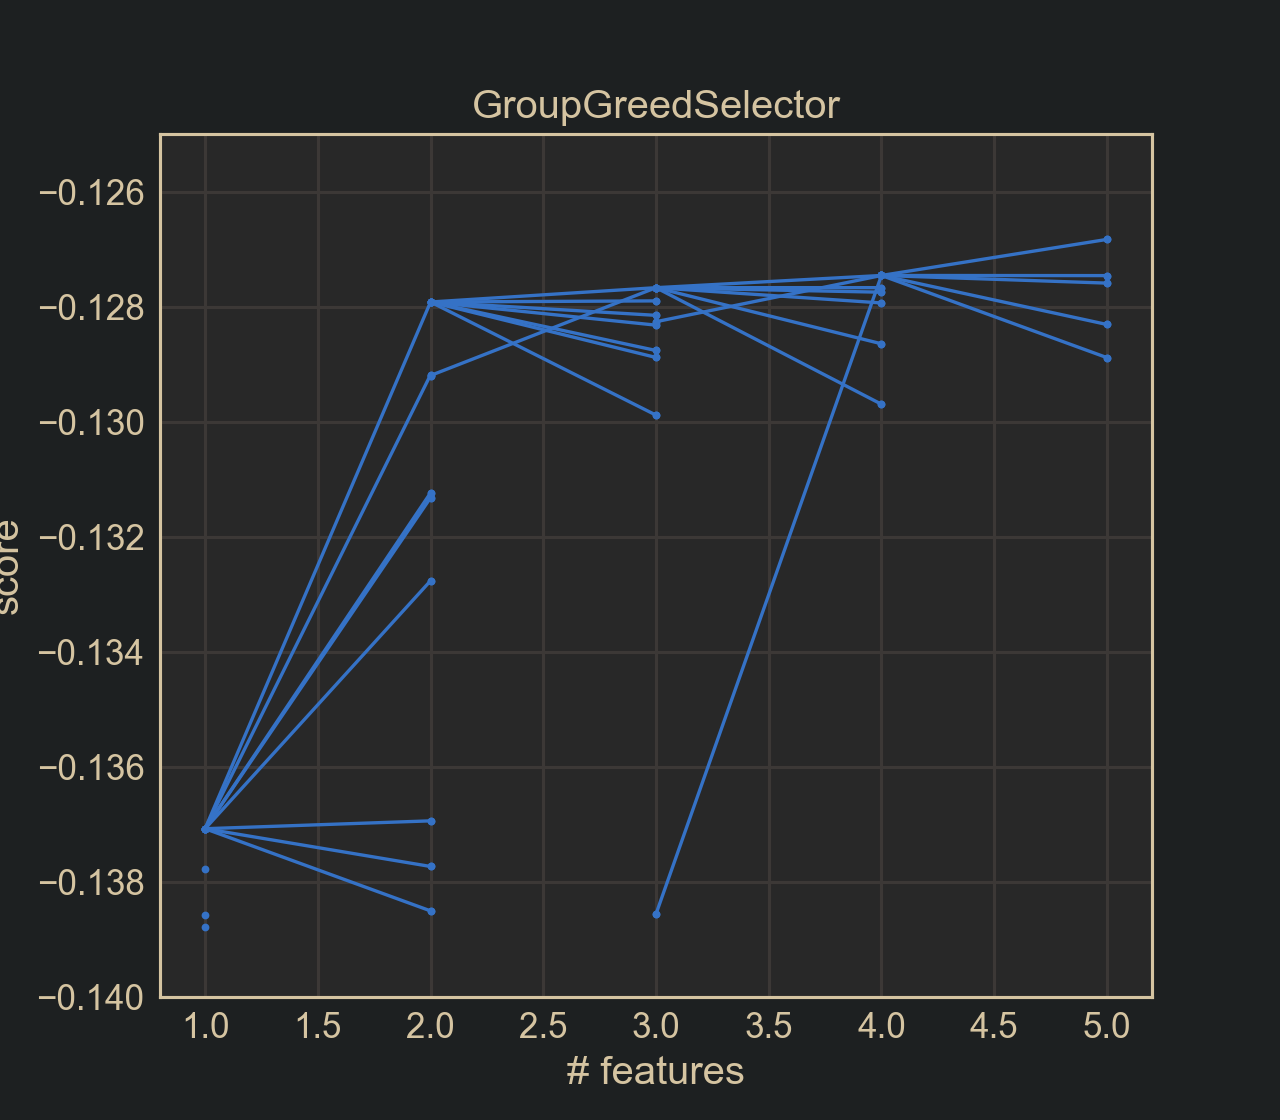

(-0.14, -0.125)

In [13]:
%matplotlib notebook

fig, ax = selector.plot_subset(color='b', marker='.')
ax.set_ylim([-0.14, -0.125])

<IPython.core.display.Javascript object>


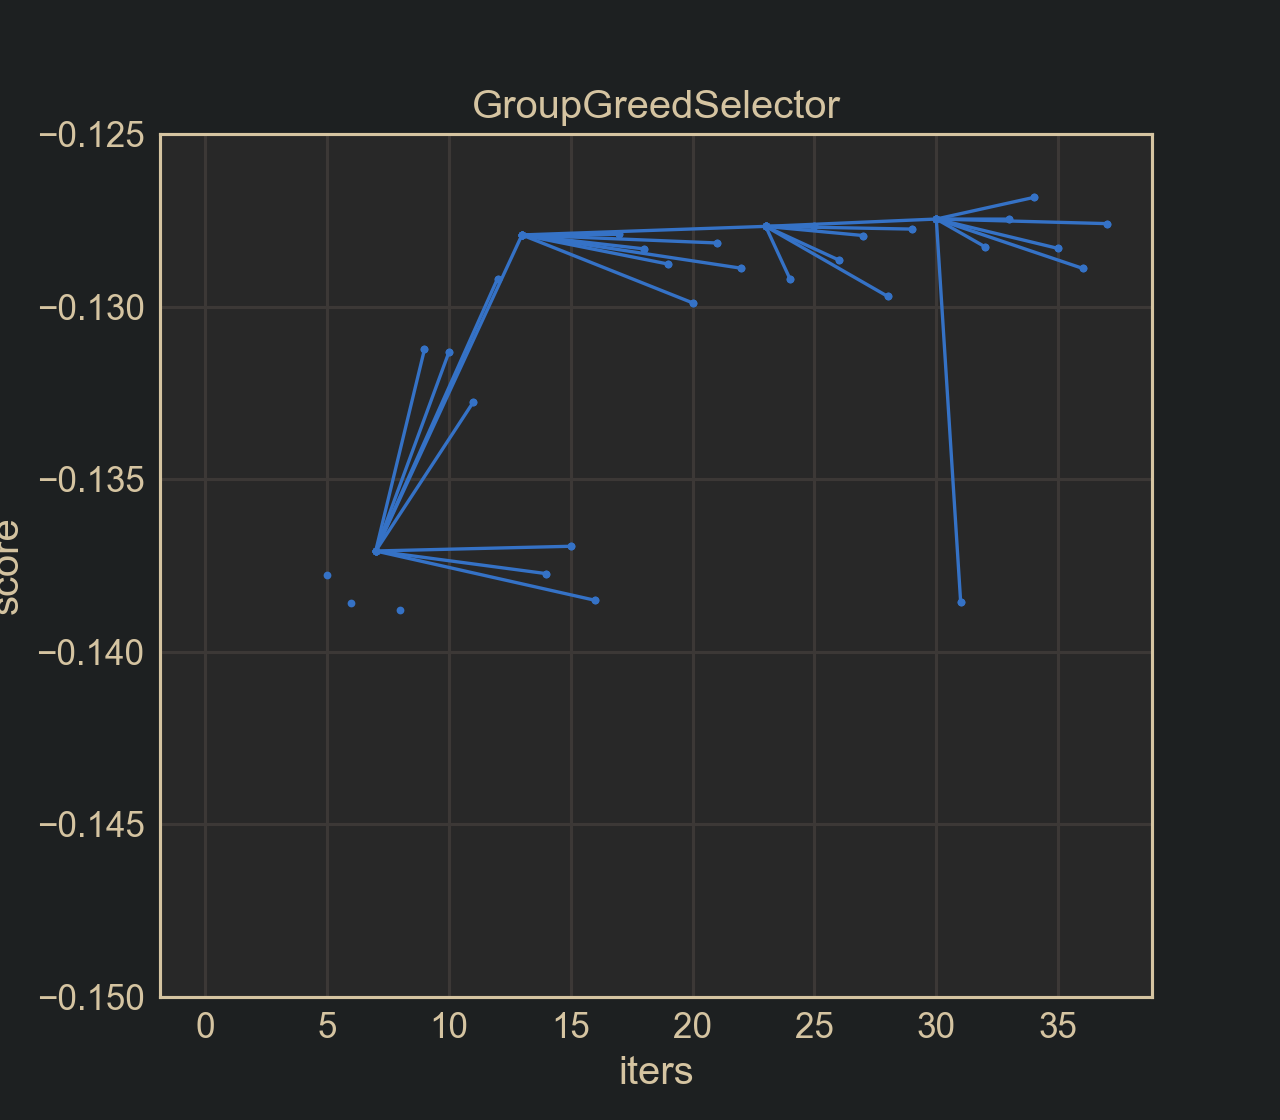

(-0.15, -0.125)

In [16]:
%matplotlib notebook

fig, ax = selector.plot_progress(color='b', marker='.')
ax.set_ylim([-0.15, -0.125])

In [18]:
features = selector.get_subset()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[00:45:48]  TransformedTargetRegressor

[00:45:54]  VAL 1:   -0.1169
[00:45:54]  VAL 2:   -0.1389
[00:45:54]  VAL 3:   -0.1311
[00:45:54]  VAL 4:   -0.1138
[00:45:54]  VAL 5:   -0.1335

[00:45:55]  VALID:   -0.1268 ± 0.0098



## Backward

In [19]:
selector = GroupGreedSelector(model, cv=cv, scoring=scoring, k_features=2, 
                              forward=False, floating=False,
                              verbose=2, n_jobs=None)
selector.fit(X_train, y_train)

[00:47:08] ITER: 1      SUBSET: 9/9      SCORE: -0.1289 ± 0.0110      
[00:47:08] STEP BACKWARD
[00:47:17] ITER: 2      SUBSET: 8/9      SCORE: -0.1289 ± 0.0111      
[00:47:26] ITER: 3      SUBSET: 8/9      SCORE: -0.1289 ± 0.0110      
[00:47:35] ITER: 4      SUBSET: 8/9      SCORE: -0.1289 ± 0.0110      
[00:47:43] ITER: 5      SUBSET: 8/9      SCORE: -0.1287 ± 0.0103      
[00:47:47] ITER: 6      SUBSET: 8/9      SCORE: -0.1286 ± 0.0098      
[00:47:55] ITER: 7      SUBSET: 8/9      SCORE: -0.1288 ± 0.0110      
[00:48:04] ITER: 8      SUBSET: 8/9      SCORE: -0.1298 ± 0.0102      
[00:48:13] ITER: 9      SUBSET: 8/9      SCORE: -0.1284 ± 0.0107      
[00:48:21] ITER: 10      SUBSET: 8/9      SCORE: -0.1297 ± 0.0103      
[00:48:21] STEP BACKWARD
[00:48:32] ITER: 11      SUBSET: 7/9      SCORE: -0.1284 ± 0.0108      
[00:48:42] ITER: 12      SUBSET: 7/9      SCORE: -0.1284 ± 0.0107      
[00:48:52] ITER: 13      SUBSET: 7/9      SCORE: -0.1284 ± 0.0107      
[00:49:02] ITER: 14    

GroupGreedSelector(cv=5,
                   estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=MultiIndexRegressor(regressor=LGBMRegressor(boosting_type='gbdt',
                                                                                                              class_weight=None,
                                                                                                              colsample_bytree=1.0,
                                                                                                              importance_type='split',
                                                                                                              learning_rate=0.1,
                                                                                                              max_depth=-1,
                              

<IPython.core.display.Javascript object>


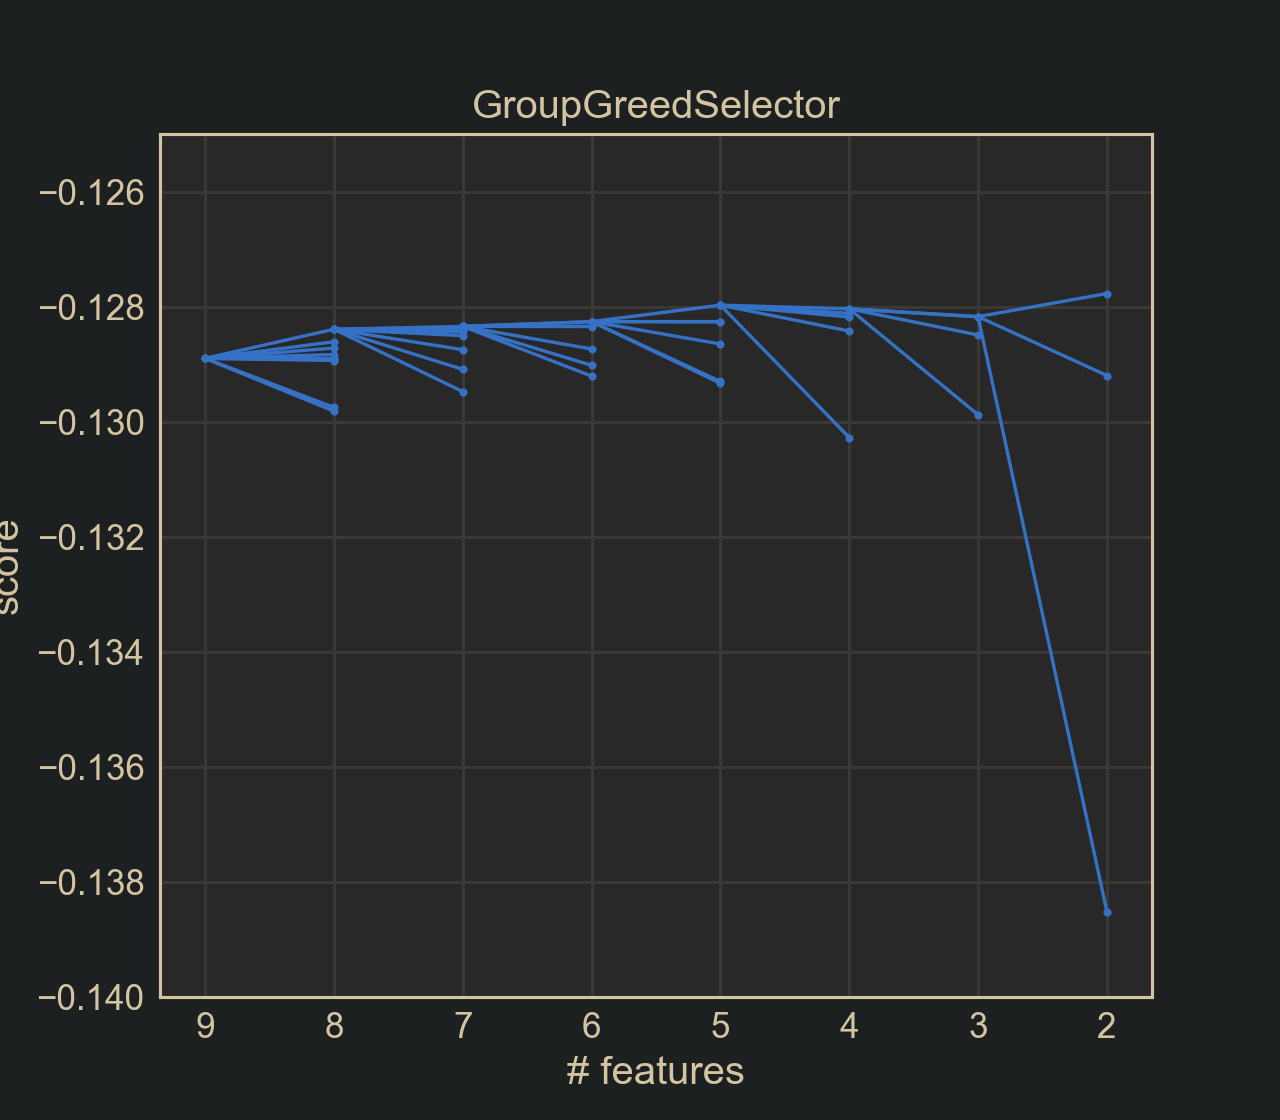

(-0.14, -0.125)

In [20]:
%matplotlib notebook

fig, ax = selector.plot_subset(color='b', marker='.')
ax.set_ylim([-0.14, -0.125])

<IPython.core.display.Javascript object>


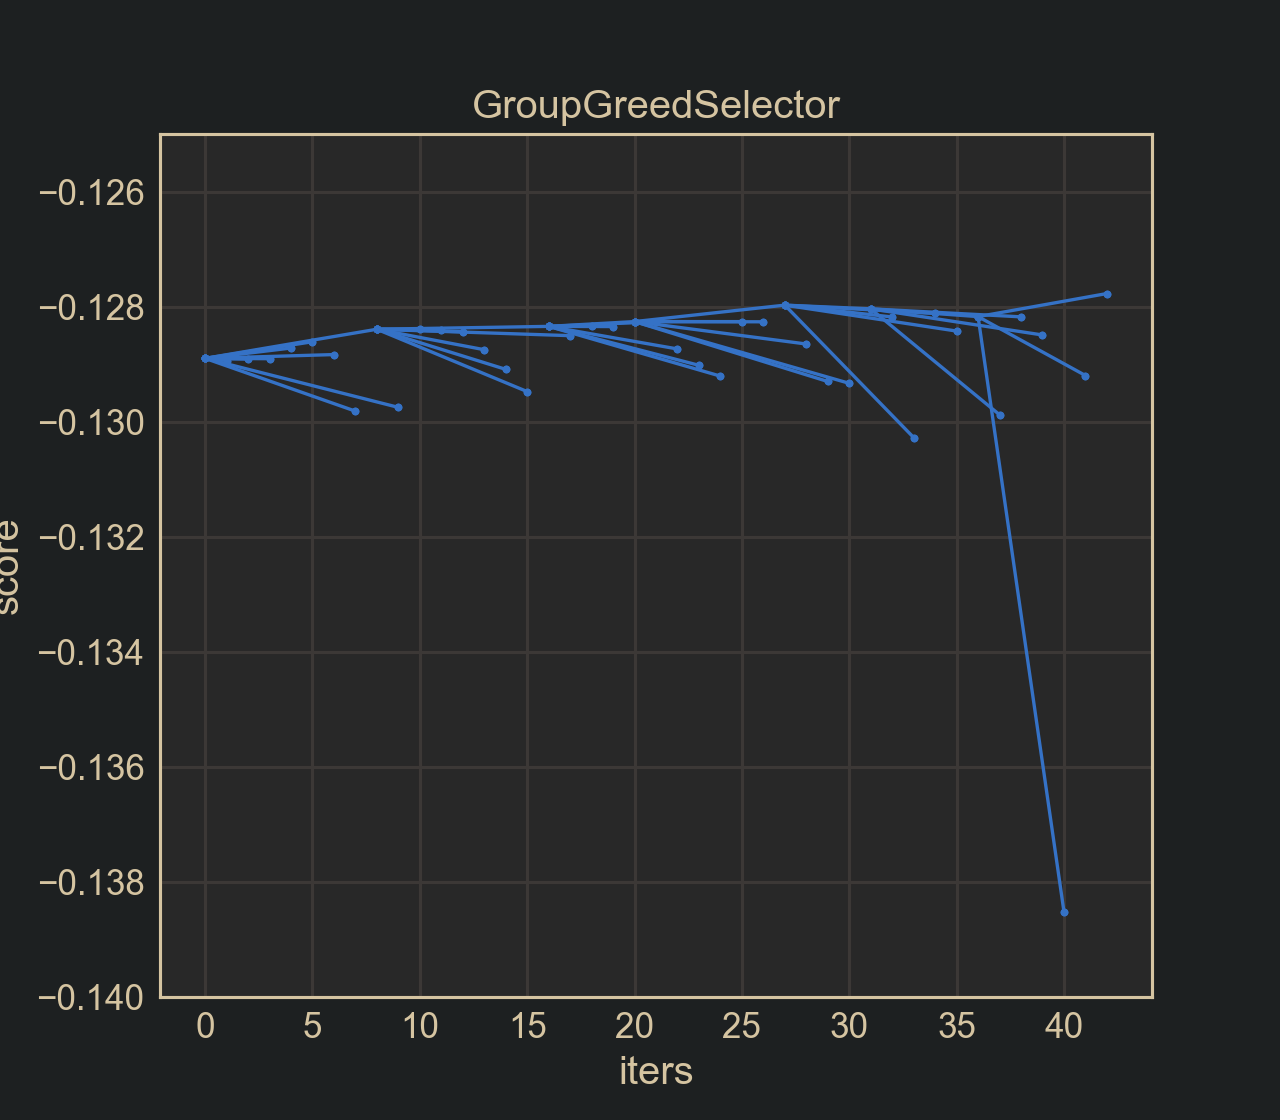

(-0.14, -0.125)

In [21]:
fig, ax = selector.plot_progress(color='b', marker='.')
ax.set_ylim([-0.14, -0.125])

In [22]:
features = selector.get_subset()

result = crossval(model, cv, X_train[features], y_train, X_new=X_test[features],
                  scoring=scoring, verbose=2, n_jobs=-1)

[01:00:17]  TransformedTargetRegressor

[01:00:22]  VAL 1:   -0.1136
[01:00:22]  VAL 2:   -0.1396
[01:00:22]  VAL 3:   -0.1346
[01:00:23]  VAL 4:   -0.1168
[01:00:23]  VAL 5:   -0.1342

[01:00:23]  VALID:   -0.1278 ± 0.0105

